
# General imports

In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import requests
from io import BytesIO


# Data importeren

## Bruggendata

In [2]:
# Lees de dexter export van brugdata in
brug = pd.read_csv('https://dqpublicblob.blob.core.windows.net/data-quality/SVM-model/brugdata/sb-bruggen-export-aalsmeerderbrug.csv',
                 low_memory=False)


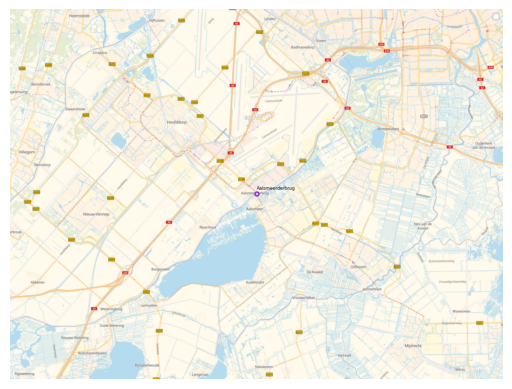

In [3]:
# Kaart van de brug
url = 'https://dqpublicblob.blob.core.windows.net/data-quality/SVM-model/brugdata/Geselecteerde%20locaties.png'

# Fetch the image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [4]:
# Zorg dat de opening en sluitingstijden echte datum/tijd velden zijn
brug['opening'] = pd.to_datetime(brug['geopend'])
brug['sluiting'] = pd.to_datetime(brug['gesloten'])


## Reistijden

In [5]:
# Lees de export van reistijden van 4 trajecten vanuit Dexter in.
rt = pd.read_csv('https://dqpublicblob.blob.core.windows.net/data-quality/SVM-model/reistijden/reistijd-export-aalsmeerderbrug-volledig.csv',
                 low_memory=False)


In [6]:
# Omdat de FCD en reistijd een vertraging heeft, verschuiven we starttijd met 6 minuten.
rt['start'] = pd.to_datetime(rt['start_meetperiode']) - pd.to_timedelta(6, 'min')

# Beschouw alleen de periode tussen 6-21 uur. Dan is er in ieder geval genoeg FCD.
rt = rt[(rt['start'].dt.hour > 6) & (rt['start'].dt.hour < 21)]

# Bekijk de eerste 5 records eens.
rt.head(5)

,id_meetlocatie,versie_meetlocatie,ndw_index,start_meetperiode,eind_meetperiode,incomplete_waarnemingen_reistijd,waarnemingen_reistijd,gebruikte_minuten_reistijd,gebruikte_rekenmethode_reistijd,spreiding_reistijd,...,hoek_graden_van_ref_punt_naar_exacte_loc,laagste_wegclassificatie,afstand_tussen_eerste_en_laatste_punt_ref_lijn,starttijd_leveringsperiode,gecalculeerde_starttijd_leveringsperiode,type_referentiewaarde,referentiewaarde_gem_reistijd,technical_exclusion,traffic_flow_deviation_exclusions,start
426,PNH03_BRG212181_A1,18,1001Z,2024-05-29 07:06:00,2024-05-29 07:07:00,NaN,100,1,NaN,NaN,...,296,FRC4,593,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-29 07:00:00
427,PNH03_BRG212181_A1,18,1001Z,2024-05-29 07:07:00,2024-05-29 07:08:00,NaN,100,1,NaN,NaN,...,296,FRC4,593,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-29 07:01:00
428,PNH03_BRG212181_A1,18,1001Z,2024-05-29 07:08:00,2024-05-29 07:09:00,NaN,100,1,NaN,NaN,...,296,FRC4,593,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-29 07:02:00
429,PNH03_BRG212181_A1,18,1001Z,2024-05-29 07:09:00,2024-05-29 07:10:00,NaN,100,1,NaN,NaN,...,296,FRC4,593,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-29 07:03:00
430,PNH03_BRG212181_A1,18,1001Z,2024-05-29 07:10:00,2024-05-29 07:11:00,NaN,100,1,NaN,NaN,...,296,FRC4,593,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-29 07:04:00


## Bewerk de reistijden
De reistijden worden geleverd in losse records voor elk traject.
Voor de analyse willen we dat de trajectdata in kolommen staat, zodat we voor elke minuut
de data kunnen gebruiken. Daarom pivoteren we de gegevens.

In [7]:
pivoted_travel_times = rt.pivot_table(index='start',
                                        columns='id_meetlocatie',
                                        values=['gem_reistijd'  #,
                                                #'kwaliteitsindicator_reistijd',
                                                #'waarnemingen_reistijd'
                                                ]
                                      )

### Nu gaan we de 'ground thruth' data toevoegen waarop we het model trainen.

In [8]:
# Voeg een kolom 'brug_open' toe
pivoted_travel_times['brug_open'] = 0

# Markeer reistijden die tijdens een brugopening vallen
# We kennen een opening de waarde 10 toe, zodat we die later makkelijker kunnen visualiseren.
for idx, row in brug.iterrows():
    mask = (pivoted_travel_times.index >= pd.to_datetime(row['opening'])) & (
            pivoted_travel_times.index <= pd.to_datetime(row['sluiting']))
    pivoted_travel_times.loc[mask, 'brug_open'] = 10

<Axes: xlabel='start'>

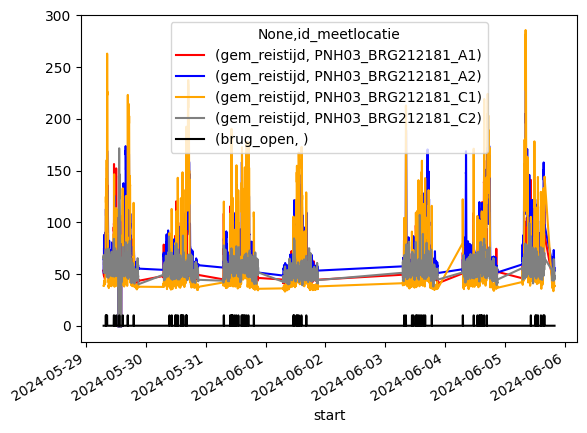

In [9]:
# Laten we de gegevens in een grafiek tonen, zodat we wat inzicht hebben in waar we naar kijken.
pivoted_travel_times.plot.line(y=pivoted_travel_times.columns, color =['red', 'blue', 'orange',
                                                                       'grey', 'black'])

# Bouwen van het model

## Data voorbereiding

In [13]:
# Selecteer de relevante features (alle kolommen) en de target variabele
# Features zijn de waarden die we gebruiken om de target te voorspellen.

features = pivoted_travel_times.columns.drop('brug_open')
target = 'brug_open'

In [14]:
# Nu bepalen we de data waarop we trainen. Dit zijn de gegevens van 29/5 tot 3/6.
traindata = pivoted_travel_times[pivoted_travel_times.index < '2024-06-03 00:00:00']
X = traindata[features]
y = traindata[target]

In [15]:
# Splits de data in trainings- en testsets
# De 80/20 regel is vaak goed. En we testen over dezelfde periode als de trainingsdata.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Resampling en normaliseren

Nu is er een probleem. De brug is veel minder vaak dicht (horizontaal) dan open (verticaal)Dus als we er niets aan doen, trainen we meer op een juiste dicht voorspelling. Dat willen we niet.

Een tweede probleem is dat de waardes van de features sterk uiteenlopen in grootte. Hiervoor kan je corrigeren door ze te normaliseren.


### Resampling

In [31]:
# Combineer X_train en y_train voor het resampling proces
train_data = pd.concat([X_train, y_train], axis=1)

# Scheid majority en minority classes
not_open = train_data[train_data['brug_open'] == 0]
open = train_data[train_data['brug_open'] == 10]

# Resample de minority class
open_upsampled = resample(open,
                          replace=True,  # sample with replacement
                          n_samples=len(not_open),  # match number in majority class
                          random_state=42)  # reproducible results

# Combineer majority en upsampled minority class
upsampled = pd.concat([not_open, open_upsampled])

# Scheid de features en de target
X_train_balanced = np.array(upsampled.drop('brug_open', axis=1))
y_train_balanced = np.array(upsampled['brug_open'])

# Print het aantal voorkomens voor brug gesloten(0) en brugopen(10)
print(np.unique(y_train_balanced, return_counts=True))

(array([ 0, 10]), array([1866, 1866]))


### Normaliseren

In [33]:
# Normaliseer de features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_balanced = scaler.fit_transform(X_train_balanced)

## Model definitie en training
We kiezen voor een Support Vector Machine classificatie model met een RBF kernel. Deze is het meest flexibel.

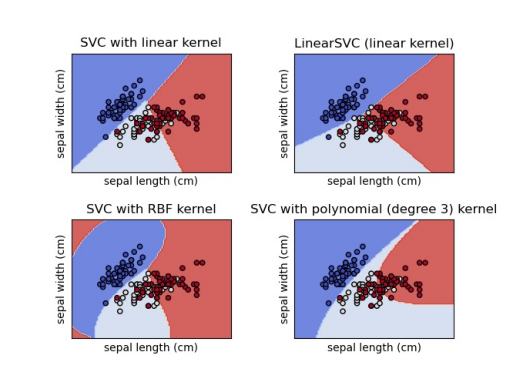

In [36]:
url = 'https://dqpublicblob.blob.core.windows.net/data-quality/SVM-model/SVM-kernels.jpg'

# Fetch the image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [34]:
# Kies een SVM met een RBF kernel
svm_model = SVC(kernel='rbf', gamma='auto')  # auto

# Train het model
svm_model.fit(X_train_balanced, y_train_balanced)

SVC(gamma='auto')

## Model testen

In [35]:
# Voorspel de test data
y_pred = svm_model.predict(X_test)


# Genereer een classificatierapport en een verwarringsmatrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[952 301]
 [  6  85]]
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1253
          10       0.22      0.93      0.36        91

    accuracy                           0.77      1344
   macro avg       0.61      0.85      0.61      1344
weighted avg       0.94      0.77      0.83      1344



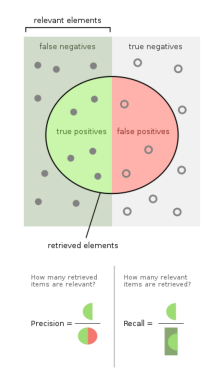

In [40]:
# https:/en.wikipedia.org/wiki/Precision_and_recall
url = 'https://dqpublicblob.blob.core.windows.net/data-quality/SVM-model/Precisionrecall.png'

# Fetch the image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Voorspelling over de gehele periode
We gaan de brugopeningen voorspellen over de gehele periode, dus ook over 4,5 en 6 juni.

In [41]:
pivoted_travel_times['prediction'] = svm_model.predict(
    scaler.transform(pivoted_travel_times[features])) * -1


Laten we dit weer in een grafiek tonen.

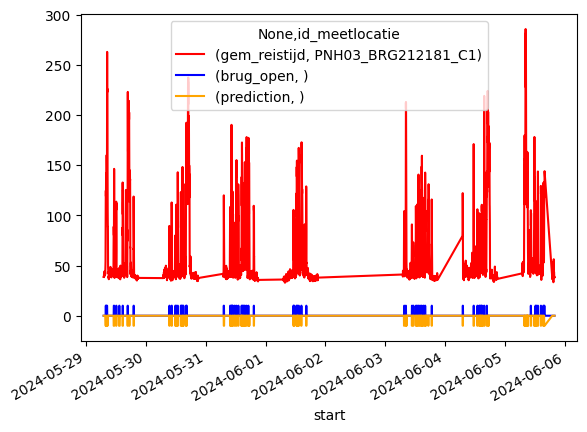

In [43]:
cols = [('gem_reistijd','PNH03_BRG212181_C1'), ('brug_open','') , ('prediction','')]
pivoted_travel_times.plot.line(y=cols, color =['red', 'blue', 'orange',
                                                                        'grey', 'black'])

plt.show()

# In de grafiek worden de waargenomen brugopeningen en de voorspellingen getoond. 

Waardoor zou de afwijking kunnen komen op 6 juni?